In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Functions

In [ ]:
def minmax_scaler(df,col):
  # Normalize the interpolated time series between [-1, 1]
  scaler = MinMaxScaler(feature_range=(-1, 1))
  df[col] = scaler.fit_transform(df[[col]])
  return df[col]

In [ ]:
def min_max(data):
    # Initialize MinMaxScaler with feature range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Reshape data if it's a 1D array to make it compatible with the scaler
    data_reshaped = data.reshape(-1, 1)

    # Fit and transform the data
    y_norm = scaler.fit_transform(data_reshaped)
    y_norm = np.clip(y_norm, -1, 1)
    # Reshape back to original shape if needed
    return y_norm.flatten()

In [ ]:
def create_linespace(df, x, y):
  x_new = np.linspace(df[x].min(), df[x].max(), num=50)
  y_new = np.interp(x_new, df[x], df[y])

  return y_new

In [ ]:
def create_batches(df,window_size, stride=1):
  batches = []
  for i in range(0, len(df) - window_size + 1, stride):
    batch = df[i : i + window_size]
    batches.append(batch)
  return batches

In [ ]:
def create_GASF(batches):
  GASF_list=[]

  for batch in batches:
    GASF = calculate_GASF(batch)
    scaler = MinMaxScaler()
    GASF_normal = scaler.fit_transform(GASF)
    GASF_normal = np.clip(GASF_normal, 0, 1)
    GASF_list.append(GASF_normal)

  return GASF_list

In [ ]:
def create_GASF2(batches):
  GASF_list=[]

  for batch in batches:
    GASF = calculate_GASF2(batch)
    scaler = MinMaxScaler()
    GASF_normal = scaler.fit_transform(GASF)
    GASF_normal = np.clip(GASF_normal, 0, 1)
    GASF_list.append(GASF_normal)

  return GASF_list

In [ ]:
def calculate_GASF(batch):
  y = create_linespace(batch,'SensorDateTime_numeric','I3_A')
    # normalize input
  y_norm = min_max(y)

  # Compute the angles using arccosine (for GASF)
  angles_ynorm = np.arccos(y_norm)

  # Compute Gramian Angular Summation Field (GASF)
  GASF_ynorm = np.cos(angles_ynorm[:, None] + angles_ynorm[None, :])

  return GASF_ynorm


In [ ]:
def calculate_GASF2(batch):
    # استخراج ستون I3_A از batch
    y = batch['I3_A'].to_numpy()

    # نرمال‌سازی داده‌ها
    y_norm = min_max(y)

    # محاسبه زوایا با استفاده از arccos
    angles_ynorm = np.arccos(y_norm)

    # محاسبه Gramian Angular Summation Field (GASF)
    GASF_ynorm = np.cos(angles_ynorm[:, None] + angles_ynorm[None, :])

    return GASF_ynorm


### Load Data

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/WashingMachine_PhaseCount_3_geq_2017-10-23_lt_2017-10-30.csv')
data = pd.read_csv('/content/drive/MyDrive/AutoEncoder (on our data)/WashingMachine_PhaseCount_3_geq_2017-10-23_lt_2017-10-30.csv')


### Preprocessing

In [ ]:
my_data = data[['SensorDateTime', 'I3_A']]

In [ ]:
my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
my_data['SensorDateTime_numeric'] = my_data['SensorDateTime'].map(pd.Timestamp.timestamp)  # تبدیل به عدد

<ipython-input-15-c99ef3356e84>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-15-c99ef3356e84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-15-c99ef3356e84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [ ]:
batches = create_batches(my_data,window_size=24,stride=5)
# GASF_list = create_GASF(batches)
# GASF_list2 = create_GASF2(batches)

### Prepare GASFs as input

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_set(window_size,stride):

  batches = create_batches(my_data,window_size=window_size,stride=stride)

  # give these for prediction
  train_data, test_data = train_test_split(batches, test_size=0.2, random_state=42)

  train_gasf = create_GASF(train_data)
  test_gasf = create_GASF(test_data)

  # give these to the network
  x_train_gasf = np.array(train_gasf)
  x_test_gasf = np.array(test_gasf)

  x_train_gasf = x_train_gasf.reshape((-1, 50, 50, 1))
  x_test_gasf = x_test_gasf.reshape((-1, 50, 50, 1))

  return x_train_gasf, x_test_gasf, train_data, test_data



In [ ]:
from sklearn.model_selection import train_test_split
def train_test_set_improved(window_size,stride):

  batches = create_batches(my_data,window_size=window_size,stride=stride)

  # give these for prediction
  train_data, test_data = train_test_split(batches, test_size=0.2, random_state=42)

  train_gasf = create_GASF2(train_data)
  test_gasf = create_GASF2(test_data)

  # give these to the network
  x_train_gasf = np.array(train_gasf)
  x_test_gasf = np.array(test_gasf)

  x_train_gasf = x_train_gasf.reshape((-1, 24, 24, 1))
  x_test_gasf = x_test_gasf.reshape((-1, 24, 24, 1))

  return x_train_gasf, x_test_gasf, train_data, test_data




### Visualize batches and GASFs

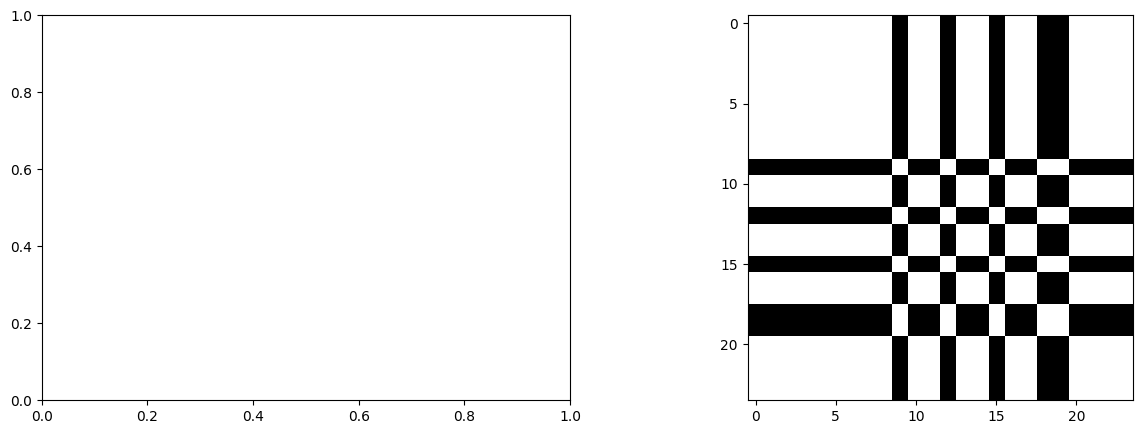

In [ ]:
GASF_y = x_test_gasf[40]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.imshow(GASF_y, cmap='gray')

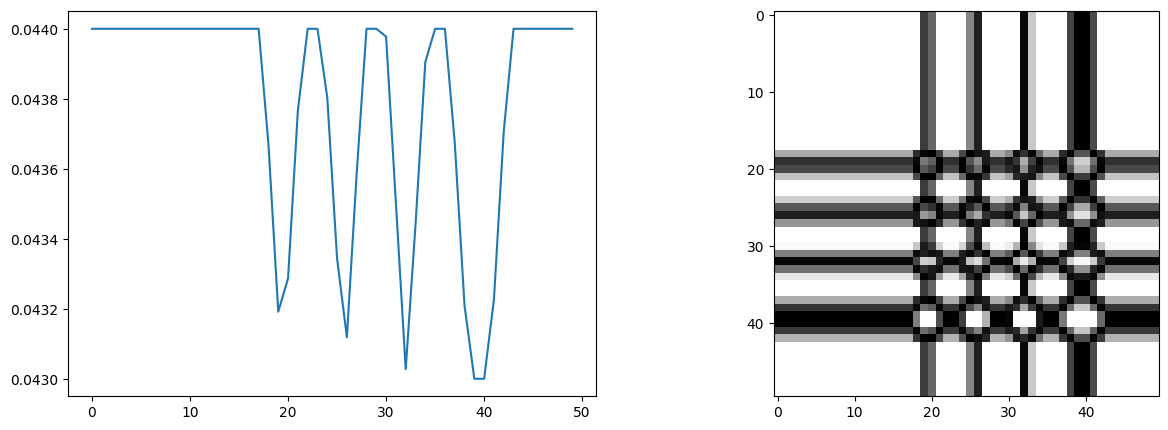

In [ ]:
y = create_linespace(test_data[40],'SensorDateTime_numeric','I3_A')
GASF_y = x_test_gasf[40]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.imshow(GASF_y, cmap='gray')
plt.show()

# VAE

## Funcitons

In [ ]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Pass the inputs through the encoder and then the decoder
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z)
        reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




In [ ]:
def train_vae(x_train, x_test,encoder, decoder, model_path):

  vae = VAE(encoder, decoder)
  vae.compile(optimizer=keras.optimizers.Adam())

  checkpoint_filepath = model_path
  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      # save_weights_only=True,
      monitor="val_loss",   # scale
      mode="min",           # best model with minimum val_loss
      save_best_only=True
  )
  early_stopping_callback = keras.callbacks.EarlyStopping(
      monitor='val_loss',   # scale
      # min_delta=5,      # minimum change to continue training
      patience=15,          # stop if it did not change after 30 epochs
      verbose=1,            # display info with some details
      mode='min',          # scale should decrease or increase
      restore_best_weights=True, # restore the best weights
  )
  tensorboard_callback = keras.callbacks.TensorBoard(
      log_dir="logs",
      histogram_freq=1,
  )
  vae.fit(x_train, epochs=300, batch_size=32, validation_data=x_test , callbacks=[model_checkpoint_callback, early_stopping_callback, tensorboard_callback])
  return vae


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_combined(vae, x_test_gasf,test_data, latent_dim, n=30):

    # Select n samples
    x_sample = x_test_gasf[:n]
    # Use the VAE to reconstruct the inputs
    reconstructed = vae(x_sample, training=False)
    # Generate random latent vectors for new images
    z_random = tf.random.normal(shape=(n, latent_dim))
    generated_samples = vae.decoder(z_random, training=False)

    # Plot the images
    plt.figure(figsize=(15,1))
    for i in range(n):
      plt.subplot(1,n,i+1)
      y = create_linespace(test_data[i],'SensorDateTime_numeric','I3_A')
      plt.plot(y)
      plt.axis('off')

    fig, axs = plt.subplots(2, n, figsize=(15, 6))
    for i in range(n):


        # Original image
        axs[0, i].imshow(x_sample[i].squeeze(), cmap='gray')
        # axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        # Reconstructed image
        axs[1, i].imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        # axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

        # Generated random image
        # axs[2, i].imshow(generated_samples[i].numpy().squeeze(), cmap='gray')
        # # axs[2, i].set_title("Generated")
        # axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_reconstructed(vae, x_test_gasf,test_data, latent_dim, n=30):
    # Select n samples
    x_sample = x_test_gasf[:n]
    # Use the VAE to reconstruct the inputs
    reconstructed = vae(x_sample, training=False)
    fig, axs = plt.subplots(1, n, figsize=(15, 10))
    for i in range(n):
        axs[i].imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


## input and output size = (24,24)

### VAE with kernel (3,3)


In [ ]:
def encoder(latent_dim):

    encoder_inputs = keras.Input(shape=(24, 24, 1))
    x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

def decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 32, activation="relu")(latent_inputs)
    x = layers.Reshape((4, 4, 32))(x)

    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)

    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)


    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


In [ ]:
d = decoder(60)
d.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          31,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 18, 18, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 20, 20, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 22, 22, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 24, 24, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 24, 24, 1)           │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,425 (228.22 KB)

 Trainable params: 58,425 (228.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
e = encoder(60)
e.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 24, 24, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 22, 22, 8)      │             80 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 20, 20, 16)     │          1,168 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 10, 10, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 16)       │          2,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 6, 6, 32)       │          4,640 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 3, 3, 32)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 288)            │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100)            │         28,900 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 60)             │          6,060 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 60)             │          6,060 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 60)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,228 (192.30 KB)

 Trainable params: 49,228 (192.30 KB)

 Non-trainable params: 0 (0.00 B)

### VAE (CNN-RNN)

In [ ]:
def encoder_gru_extended(latent_dim):
    encoder_inputs = keras.Input(shape=(24,24, 1))

    x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Reshape((9,64))(x)

    # RNN
    x = layers.GRU(128,activation='relu', return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.Lambda(lambda t: t[:, -64:, :])(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def decoder_gru_extended(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = layers.Dense(128, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 16))(x)

    # # RNN
    x = layers.GRU(32,activation='relu', return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    # x = layers.Lambda(lambda t: t[:, -64:, :])(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Reshape((4,4, 64))(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)

    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)

    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


In [ ]:
enc = encoder_gru_extended(40)
enc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 24, 24, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 22, 22, 8)      │             80 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 20, 20, 16)     │          1,168 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 10, 10, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 16)       │          2,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 6, 6, 32)       │          4,640 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 3, 3, 32)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3, 3, 64)       │          2,112 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 9, 64)          │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 9, 128)         │         74,496 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 9, 128)         │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 9, 32)          │         15,552 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 9, 32)          │              0 │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 9, 32)          │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 288)            │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         36,992 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 40)             │          5,160 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 40)             │          5,160 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)  

 Total params: 147,680 (576.88 KB)

 Trainable params: 147,680 (576.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
dec = decoder_gru_extended(40)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 8, 32)               │           4,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 8, 128)              │          62,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 6, 6, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 18, 18, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 20, 20, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 22, 22, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 24, 24, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 24, 24, 1)           │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,665 (424.47 KB)

 Trainable params: 108,665 (424.47 KB)

 Non-trainable params: 0 (0.00 B)

## input and output size = (50,50)

#### VAE with kernel (3,3)


In [ ]:
def encoder(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(400, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

def decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(3 * 3 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((3, 3, 64))(x)

    x = layers.Conv2DTranspose(64, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)

    x = layers.UpSampling2D(size=(3, 3))(x)

    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)


    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


In [ ]:
e = encoder(60)
e.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 50, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 8)      │             80 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 46, 46, 16)     │          1,168 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 23, 23, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 21, 21, 16)     │          2,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 19, 19, 32)     │          4,640 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 9, 9, 32)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2592)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 400)            │      1,037,200 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 60)             │         24,060 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 60)             │         24,060 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 60)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,093,528 (4.17 MB)

 Trainable params: 1,093,528 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
d = decoder(60)
d.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 576)                 │          35,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 5, 5, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 7, 7, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 23, 23, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 50, 50, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 50, 50, 1)           │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,569 (412.38 KB)

 Trainable params: 105,569 (412.38 KB)

 Non-trainable params: 0 (0.00 B)

#### VAE with kernel (3,1)

In [ ]:
def encoder_k31(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, (3,1), activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (3,1), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)

    x = layers.Dense(400, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

def encoder_k31_13(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, (3,1), activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(16, (1,3), activation="relu")(x)
    x = layers.Conv2D(16, (1,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (1,3), activation="relu")(x)
    x = layers.Conv2D(32, (1,3), activation="relu")(x)

    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(400, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

def encoder_k3113(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, (3,1), activation="relu")(encoder_inputs)
    x = layers.Conv2D(8, (1,3), activation="relu")(x)
    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(16, (1,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(16, (1,3), activation="relu")(x)
    x = layers.Conv2D(32, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (1,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(400, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

def encoder_k31_then_13(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, (3,1), activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (3,1), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(3,3))(x)


    x = layers.Conv2D(32, (1,3), activation="relu")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(400, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder


def encoder_k31_then_13_mp21(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, (3,1), activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,1))(x)

    x = layers.Conv2D(16, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (3,1), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,1))(x)

    x = layers.Conv2D(32, (1,3), activation="relu")(x)
    x = layers.Conv2D(32, (1,3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(1,2))(x)
    x = layers.Conv2D(32, (1,3), activation="relu")(x)
    x = layers.Conv2D(32, (1,3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(1,2))(x)


    # x = layers.Conv2D(32, (1,3), activation="relu")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(400, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder


def decoder_k31(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(3 * 3 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((3, 3, 64))(x)

    x = layers.Conv2DTranspose(64, (3,1), activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3,1), activation='relu')(x)

    x = layers.UpSampling2D(size=(3, 3))(x)

    x = layers.Conv2DTranspose(32, (3,1), activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(16, (3,1), activation='relu')(x)
    x = layers.Conv2DTranspose(8, (3,1), activation='relu')(x)
    x = layers.Conv2DTranspose(8, (1,33), activation='relu')(x)


    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


In [ ]:
# dec = decoder_k31(10)
enc = encoder_k3113(10)
enc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 48, 50, 8)      │             32 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 48, 48, 8)      │            200 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 46, 48, 16)     │            400 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 46, 46, 16)     │            784 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 23, 23, 16)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 21, 23, 16)     │            784 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 21, 21, 16)     │            784 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 19, 21, 32)     │          1,568 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 19, 19, 32)     │          3,104 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 9, 9, 32)       │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2592)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 400)            │      1,037,200 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │          4,010 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │          4,010 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,052,876 (4.02 MB)

 Trainable params: 1,052,876 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

#### VAE LSTM

In [ ]:
def encoder_lstm(latent_dim):

    encoder_inputs = keras.Input(shape=(50, 50, 1))
    x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, (3,1), activation="relu")(x)
    x = layers.Conv2D(32, (3,1), activation="relu")(x)

    x = layers.Reshape((-1, 32))(x)  # H * W as timesteps, C as features
    x = layers.LSTM(64, return_sequences=True)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(400, activation="relu")(x)


    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder


In [ ]:
enc = encoder_lstm(10)
enc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 48, 48, 8)      │             80 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 46, 46, 16)     │          1,168 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 23, 23, 16)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 21, 21, 16)     │          2,320 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 19, 19, 32)     │          4,640 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 9, 9, 32)       │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 7, 9, 32)       │          3,104 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 5, 9, 32)       │          3,104 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 45, 32)         │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 45, 64)         │         24,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2880)           │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 400)            │      1,152,400 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │          4,010 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │          4,010 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,199,668 (4.58 MB)

 Trainable params: 1,199,668 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

#### VAE (CNN-RNN)


*   I removed 2 dense layers before the gru cell
*   I passed 8 time steps to each gru cell
*   I removed flatten and dense layers
*   I used a Conv2D instead of conv2DTranspose to adjusts the shapes without adding any new layers

BUT IT DID NOT WORK





In [ ]:
def encoder_gru_extended(latent_dim):
    encoder_inputs = keras.Input(shape=(50, 50, 1))

    x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation="relu")(x)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Reshape((9*9,64))(x)

    # RNN
    x = layers.GRU(128,activation='relu', return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.Lambda(lambda t: t[:, -64:, :])(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)


    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

def decoder_gru_extended(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = layers.Dense(128, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 16))(x)

    # # RNN
    x = layers.GRU(32,activation='relu', return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(128, return_sequences=True)(x)
    # x = layers.Lambda(lambda t: t[:, -64:, :])(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Reshape((4,4, 64))(x)

    x = layers.Conv2DTranspose(64, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)

    x = layers.UpSampling2D(size=(3, 3))(x)

    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(16, 3, activation='relu')(x)


    # x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    # x = layers.Conv2DTranspose(8, 3, activation='relu')(x)


    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder


In [ ]:
dec = decoder_gru_extended(10)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_29 (Reshape)                 │ (None, 8, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_34 (GRU)                         │ (None, 8, 32)               │           4,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 8, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_35 (GRU)                         │ (None, 8, 128)              │          62,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_30 (Reshape)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_86                  │ (None, 6, 6, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_87                  │ (None, 8, 8, 32)            │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_22 (UpSampling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_88                  │ (None, 26, 26, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_23 (UpSampling2D)      │ (None, 52, 52, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 50, 50, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_89                  │ (None, 50, 50, 1)           │              17 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,769 (510.82 KB)

 Trainable params: 130,769 (510.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
enc = encoder_gru_extended(10)
enc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 50, 50, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 48, 48, 8)      │             80 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 46, 46, 16)     │          1,168 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 23, 23, 16)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 21, 21, 16)     │          2,320 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 19, 19, 32)     │          4,640 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 9, 9, 32)       │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 9, 9, 64)       │          2,112 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_28 (Reshape)      │ (None, 81, 64)         │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_32 (GRU)              │ (None, 81, 128)        │         74,496 │ reshape_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 81, 128)        │              0 │ gru_32[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_33 (GRU)              │ (None, 81, 32)         │         15,552 │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 64, 32)         │              0 │ gru_33[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 64, 32)         │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2048)           │              0 │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 512)            │      1,049,088 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │         65,664 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │          1,290 │ dense_22[0][0]         │
├──────────────────────

 Total params: 1,217,700 (4.65 MB)

 Trainable params: 1,217,700 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# فرض کنید که encoder و decoder شما به درستی تعریف شده‌اند
# تعریف مدل VAE
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

# تابع برای محاسبه reconstruction loss
def compute_reconstruction_loss(model, inputs):
    reconstructed = model(inputs)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(inputs, reconstructed),
            axis=(1, 2)
        )
    )
    return reconstruction_loss

# ساختن نمونه‌ای از داده‌های ورودی
input_image = tf.random.normal([1, 24, 24, 1])  # یک تصویر تصادفی به ابعاد (24, 24, 1)

# فرض کنید encoder و decoder شما آماده هستند
vae_model = VAE(encoder, decoder)

# محاسبه reconstruction loss
loss = compute_reconstruction_loss(vae_model, input_image)
print(f"Reconstruction Loss: {loss.numpy()}")


ValueError: Exception encountered when calling VAE.call().

[1mInvalid dtype: <property object at 0x79ff56bf7600>[0m

Arguments received by VAE.call():
  • inputs=tf.Tensor(shape=(1, 24, 24, 1), dtype=float32)

# Train VAE

In [ ]:
rm -rf ./logs/

## input and output size = (24,24)

### change latent dim

####d=40

In [ ]:
'''
    w = 24
    d = 40

    epochs = 300
    patience = 15
    early stop at : 243
    val_loss = 94
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(40)
dec = decoder(40)
vae_cnn_inout24_d40_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d40_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 6.1156 - loss: 292.7815 - reconstruction_loss: 286.6658

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - kl_loss: 6.1157 - loss: 292.7147 - reconstruction_loss: 286.5989 - val_kl_loss: 3.7946 - val_loss: 224.7149 - val_reconstruction_loss: 220.9204
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 4.9233 - loss: 226.3195 - reconstruction_loss: 221.3962 - val_kl_loss: 4.9172 - val_loss: 215.1910 - val_reconstruction_loss: 210.2738
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 4.7692 - loss: 216.7672 - reconstruction_loss: 211.9981 - val_kl_loss: 3.9037 - val_loss: 213.4925 - val_reconstruction_loss: 209.5888
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 4.4998 - loss: 217.8236 - reconstruction_loss: 213.3238 - val_kl_loss: 2.6297 - val_loss: 212.4406 - val_reconstruction_loss: 209.8108
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 3.3768 - loss: 215.1107 - reconstruction_loss: 211.7339 - val_kl_loss: 2.5120 - val_loss: 212.1612 - val_reconstruction_loss: 209.6492
Epoch 6/300
553

#### d = 60

In [ ]:
'''
    w = 24
    d = 60

    epochs = 300
    patience = 15
    early stop at : 125
    val_loss = 108
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(60)
dec = decoder(60)
vae_cnn_inout24_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d60_w24.keras')

NameError: name 'train_test_set_improved' is not defined

#### d = 100

In [ ]:
'''
    w = 24
    d = 100

    epochs = 300
    patience = 15
    early stop at : 236
    val_loss = 86
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(100)
dec = decoder(100)
vae_cnn_inout24_d100_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d100_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 5.2086 - loss: 333.4751 - reconstruction_loss: 328.2665

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - kl_loss: 5.2116 - loss: 333.3784 - reconstruction_loss: 328.1668 - val_kl_loss: 12.3290 - val_loss: 234.6797 - val_reconstruction_loss: 222.3507
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - kl_loss: 5.7571 - loss: 226.5644 - reconstruction_loss: 220.8073 - val_kl_loss: 4.0504 - val_loss: 216.2742 - val_reconstruction_loss: 212.2238
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 5.1420 - loss: 218.1683 - reconstruction_loss: 213.0264 - val_kl_loss: 5.1054 - val_loss: 214.7107 - val_reconstruction_loss: 209.6053
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - kl_loss: 5.2040 - loss: 218.0515 - reconstruction_loss: 212.8475 - val_kl_loss: 5.9528 - val_loss: 215.5498 - val_reconstruction_loss: 209.5969
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 4.4666 - loss: 216.6800 - reconstruction_loss: 212.2134 - val_kl_loss: 3.7894 - val_loss: 213.5098 - val_reconstruction_loss: 209.7204
Epoch 6/300
5

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - kl_loss: 8.2375 - loss: 291.5452 - reconstruction_loss: 283.3077 - val_kl_loss: 8.0419 - val_loss: 217.5552 - val_reconstruction_loss: 209.5133
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 4.8921 - loss: 218.8294 - reconstruction_loss: 213.9374 - val_kl_loss: 5.5803 - val_loss: 215.1610 - val_reconstruction_loss: 209.5808
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 4.7675 - loss: 218.9923 - reconstruction_loss: 214.2250 - val_kl_loss: 4.8777 - val_loss: 212.6336 - val_reconstruction_loss: 207.7559
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 5.2286 - loss: 214.9237 - reconstruction_loss: 209.6951 - val_kl_loss: 5.3183 - val_loss: 195.2051 - val_reconstruction_loss: 189.8869
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 5.9290 - loss: 195.6624 - reconstruction_loss: 189.7335 - val_kl_loss: 6.4563 - val_loss: 183.8852 - val_reconstruction_loss: 177.4289
Epoch 6/300
553

#### d = 150

In [ ]:
'''
    w = 24
    d = 150

    epochs = 300
    patience = 15
    early stop at : 182
    val_loss = 107
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(150)
dec = decoder(150)
vae_cnn_inout24_d150_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d150_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 5.9315 - loss: 327.3605 - reconstruction_loss: 321.4290

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - kl_loss: 5.9344 - loss: 327.2649 - reconstruction_loss: 321.3305 - val_kl_loss: 4.0090 - val_loss: 228.4531 - val_reconstruction_loss: 224.4441
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - kl_loss: 5.3872 - loss: 226.2426 - reconstruction_loss: 220.8554 - val_kl_loss: 7.1624 - val_loss: 218.6075 - val_reconstruction_loss: 211.4451
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 4.9639 - loss: 216.0990 - reconstruction_loss: 211.1350 - val_kl_loss: 7.1764 - val_loss: 216.6808 - val_reconstruction_loss: 209.5045
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 5.5984 - loss: 217.8884 - reconstruction_loss: 212.2899 - val_kl_loss: 4.5461 - val_loss: 214.4438 - val_reconstruction_loss: 209.8977
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 5.3997 - loss: 218.7014 - reconstruction_loss: 213.3018 - val_kl_loss: 4.0776 - val_loss: 216.7902 - val_reconstruction_loss: 212.7126
Epoch 6/300
55

#### d = 200

In [ ]:
'''
    w = 24
    d = 200

    epochs = 300
    patience = 15
    early stop at : 182
    val_loss = 100
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(200)
dec = decoder(200)
vae_cnn_inout24_d200_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d200_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 6.4162 - loss: 300.3632 - reconstruction_loss: 293.9469

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - kl_loss: 6.4176 - loss: 300.2749 - reconstruction_loss: 293.8572 - val_kl_loss: 7.4698 - val_loss: 219.2485 - val_reconstruction_loss: 211.7787
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.2400 - loss: 216.8305 - reconstruction_loss: 211.5905 - val_kl_loss: 4.0601 - val_loss: 227.0184 - val_reconstruction_loss: 222.9583
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 5.5372 - loss: 217.0779 - reconstruction_loss: 211.5407 - val_kl_loss: 4.0298 - val_loss: 209.6945 - val_reconstruction_loss: 205.6648
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 5.2420 - loss: 215.9476 - reconstruction_loss: 210.7055 - val_kl_loss: 4.3529 - val_loss: 208.7868 - val_reconstruction_loss: 204.4339
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 6.5409 - loss: 206.4070 - reconstruction_loss: 199.8661 - val_kl_loss: 9.6463 - val_loss: 197.8548 - val_reconstruction_loss: 188.2085
Epoch 6/300
553

### VAE (CNN-RNN)

In [ ]:
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder_gru_extended(40)
dec = decoder_gru_extended(40)
vae_gru_based_inout24_d40_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_inout25_d40_w24.keras')
vae_gru_based_inout24_d40_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_inout25_d40_w24.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
'''
    w = 24
    d = 40
    autoencoder  : gru based

    epochs = 300
    patience = 15
    early stop at : 135
    val_loss = 125
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder_gru_extended(40)
dec = decoder_gru_extended(40)
vae_gru_based_inout24_d40_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_inout25_d40_w24.keras')


Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - kl_loss: 5.7634 - loss: 319.0397 - reconstruction_loss: 313.2763

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - kl_loss: 5.7659 - loss: 318.9546 - reconstruction_loss: 313.1887 - val_kl_loss: 6.2730 - val_loss: 232.1639 - val_reconstruction_loss: 225.8909
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - kl_loss: 5.9497 - loss: 226.9783 - reconstruction_loss: 221.0285 - val_kl_loss: 6.7770 - val_loss: 219.0254 - val_reconstruction_loss: 212.2483
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - kl_loss: 6.3213 - loss: 220.2867 - reconstruction_loss: 213.9654 - val_kl_loss: 4.7473 - val_loss: 214.5472 - val_reconstruction_loss: 209.7999
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - kl_loss: 5.0955 - loss: 219.2280 - reconstruction_loss: 214.1325 - val_kl_loss: 6.0005 - val_loss: 215.6635 - val_reconstruction_loss: 209.6629
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - kl_loss: 4.9623 - loss: 218.4974 - reconstruction_loss: 213.5351 - val_kl_loss: 3.4582 - val_loss: 212.4433 - val_reconstruction_loss: 208.9850
Epoch 6

## input and output size = (50,50)

#### Lower window-size

In [ ]:
'''
    w = 24
    d = 10

    epochs = 300
    patience = 15
    early stop at : 85
    val_loss = 415
'''
enc = encoder(10)
dec = decoder(10)
vae_cnn_d10_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d10_w24.keras')

Epoch 1/300


KeyboardInterrupt: 

In [ ]:
'''
    w = 12
    d = 10

    epochs = 300
    patience = 15
    early stop at : 199
    val_loss = 385
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 12,stride=5)
enc = encoder(10)
dec = decoder(10)
vae_cnn_d10_w12 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d10_w12.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - kl_loss: 14.3581 - loss: 1064.8036 - reconstruction_loss: 1050.4454

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - kl_loss: 14.3594 - loss: 1064.5211 - reconstruction_loss: 1050.1615 - val_kl_loss: 4.4916 - val_loss: 805.3762 - val_reconstruction_loss: 800.8847
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 9.7093 - loss: 810.3995 - reconstruction_loss: 800.6907 - val_kl_loss: 4.5525 - val_loss: 786.8395 - val_reconstruction_loss: 782.2872
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - kl_loss: 7.8765 - loss: 800.3334 - reconstruction_loss: 792.4567 - val_kl_loss: 3.1828 - val_loss: 783.3989 - val_reconstruction_loss: 780.2160
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 11.4644 - loss: 801.8420 - reconstruction_loss: 790.3779 - val_kl_loss: 1.8703 - val_loss: 781.5445 - val_reconstruction_loss: 779.6744
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - kl_loss: 3.2802 - loss: 796.1474 - reconstruction_loss: 792.8672 - val_kl_loss: 8.4548 - val_loss: 694.0536 - val_reconstruction_loss: 685.5989
Epoch 6/

#### Change latent-dim

In [ ]:
'''
    w = 24
    d = 20

    epochs = 300
    patience = 15
    early stop at : 199
    val_loss = 385
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size=24,stride=5)
enc = encoder(20)
dec = decoder(20)
vae_cnn_d20_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d20_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 15.7146 - loss: 1166.1692 - reconstruction_loss: 1150.4548

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - kl_loss: 15.7097 - loss: 1165.9630 - reconstruction_loss: 1150.2537 - val_kl_loss: 5.2371 - val_loss: 950.0537 - val_reconstruction_loss: 944.8167
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 7.8988 - loss: 954.8350 - reconstruction_loss: 946.9359 - val_kl_loss: 12.0391 - val_loss: 921.4108 - val_reconstruction_loss: 909.3721
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 7.0768 - loss: 928.8658 - reconstruction_loss: 921.7892 - val_kl_loss: 15.2391 - val_loss: 922.5977 - val_reconstruction_loss: 907.3590
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 39.7631 - loss: 1015.3312 - reconstruction_loss: 975.5681 - val_kl_loss: 5.0230 - val_loss: 904.1462 - val_reconstruction_loss: 899.1232
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.8912 - loss: 909.6630 - reconstruction_loss: 904.7720 - val_kl_loss: 7.2345 - val_loss: 844.9076 - val_reconstruction_loss: 837.6732
Epoch 6

In [ ]:
'''
    w = 24
    d = 40

    epochs = 300
    patience = 15
    early stop at : 81
    val_loss = 366
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder(40)
dec = decoder(40)
vae_cnn_d40_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d40_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - kl_loss: 24.4583 - loss: 1084.4913 - reconstruction_loss: 1060.0331

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - kl_loss: 24.4524 - loss: 1084.2430 - reconstruction_loss: 1059.7906 - val_kl_loss: 11.9111 - val_loss: 817.3091 - val_reconstruction_loss: 805.3980
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 14.5325 - loss: 803.9233 - reconstruction_loss: 789.3909 - val_kl_loss: 24.9836 - val_loss: 744.1805 - val_reconstruction_loss: 719.1969
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 22.3788 - loss: 721.6330 - reconstruction_loss: 699.2547 - val_kl_loss: 26.7997 - val_loss: 665.3358 - val_reconstruction_loss: 638.5361
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - kl_loss: 26.6689 - loss: 655.6010 - reconstruction_loss: 628.9323 - val_kl_loss: 25.2416 - val_loss: 619.0698 - val_reconstruction_loss: 593.8281
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 29.2868 - loss: 628.8691 - reconstruction_loss: 599.5825 - val_kl_loss: 25.5425 - val_loss: 601.3284 - val_reconstruction_loss: 575.7

In [ ]:
'''
    w = 24
    d = 60

    epochs = 300
    patience = 15
    early stop at : 109
    val_loss = 373
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder(60)
dec = decoder(60)
vae_cnn_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d60_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - kl_loss: 22.6990 - loss: 1100.1205 - reconstruction_loss: 1077.4211

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - kl_loss: 22.6930 - loss: 1099.8229 - reconstruction_loss: 1077.1295 - val_kl_loss: 16.3872 - val_loss: 787.7321 - val_reconstruction_loss: 771.3450
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 18.6136 - loss: 781.1592 - reconstruction_loss: 762.5458 - val_kl_loss: 20.5004 - val_loss: 695.1516 - val_reconstruction_loss: 674.6512
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 25.8658 - loss: 695.6108 - reconstruction_loss: 669.7451 - val_kl_loss: 28.3517 - val_loss: 632.3250 - val_reconstruction_loss: 603.9733
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 29.0283 - loss: 633.5042 - reconstruction_loss: 604.4759 - val_kl_loss: 27.7937 - val_loss: 597.2953 - val_reconstruction_loss: 569.5018
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 29.3373 - loss: 608.1860 - reconstruction_loss: 578.8488 - val_kl_loss: 28.8118 - val_loss: 570.6156 - val_reconstruction_loss: 541.8040
E

In [ ]:
'''
    w = 24
    d = 128

    epochs = 300
    patience = 15
    early stop at : 87
    val_loss = 369
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder(128)
dec = decoder(128)
vae_cnn_d128_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d128_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 38.0574 - loss: 1097.8230 - reconstruction_loss: 1059.7653

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - kl_loss: 38.0344 - loss: 1097.5374 - reconstruction_loss: 1059.5027 - val_kl_loss: 22.9543 - val_loss: 824.5103 - val_reconstruction_loss: 801.5561
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - kl_loss: 19.3962 - loss: 806.4197 - reconstruction_loss: 787.0236 - val_kl_loss: 22.8623 - val_loss: 732.7570 - val_reconstruction_loss: 709.8945
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 26.0979 - loss: 739.0394 - reconstruction_loss: 712.9416 - val_kl_loss: 28.6229 - val_loss: 683.4778 - val_reconstruction_loss: 654.8552
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 30.2387 - loss: 685.5204 - reconstruction_loss: 655.2819 - val_kl_loss: 33.3885 - val_loss: 646.9982 - val_reconstruction_loss: 613.6099
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - kl_loss: 34.5861 - loss: 657.3340 - reconstruction_loss: 622.7477 - val_kl_loss: 32.6859 - val_loss: 619.7825 - val_reconstruction_loss: 587.0966

#### Change kernel-size

In [ ]:
'''
    w = 24
    d = 60
    encoder_k = (3,1)
    decoder_k = (3,1)

    epochs = 300
    patience = 15
    early stop at : 188
    val_loss = 402
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_k31(60)
dec = decoder_k31(60)
vae_cnn_k31_60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_k31_d60_w24.keras')

KeyboardInterrupt: 

##### encoder: kernel (3,1) and (1,3)   decoder: kernel(3,3)

In [ ]:
'''
    w = 24
    d = 60
    endoder_k = (3,1) and (1,3)
    decoder_k = (3,3)


    epochs = 300
    patience = 15
    early stop at : 108
    val_loss = 369
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_k31_13(60)
dec = decoder(60)
vae_cnn_enck_31_13_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(31,13)_d60_w24.keras')

##### encoder: kernel (3,1) then (1,3)   decoder: kernel(3,3)


In [ ]:
'''
    w = 24
    d = 60
    endoder_k = (3,1) then (1,3)
    decoder_k = (3,3)


    epochs = 300
    patience = 15
    early stop at : 107
    val_loss = 393
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_k31_then_13(60)
dec = decoder(60)
vae_cnn_enck_31_then_13_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_enck(31 then 13)_d60_w24.keras')

##### encoder: kernel (3,1) then (1,3) and maxpool (2,1)   decoder: kernel(3,3)

In [ ]:
'''
    w = 24
    d = 60
    endoder_k = (3,1) then (1,3) and maxpool (2,1) (1,2)
    decoder_k = (3,3)


    epochs = 300
    patience = 15
    early stop at : 179
    val_loss = 385
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_k31_then_13_mp21(60)
dec = decoder(60)
vae_cnn_enck_31_then_13_mp21_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_enck(31 then 13)_mp21_d60_w24.keras')

##### VAE LSTM

In [ ]:
'''
    w = 24
    d = 60
    endoder = conv2D + LSTM


    epochs = 300
    patience = 15
    early stop at :
    val_loss =
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_lstm(60)
dec = decoder(60)
vae_cnn_lstm_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_lstm_d60_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - kl_loss: 17.6376 - loss: 1149.0800 - reconstruction_loss: 1131.4419

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - kl_loss: 17.6345 - loss: 1148.8999 - reconstruction_loss: 1131.2650 - val_kl_loss: 4.3961 - val_loss: 962.2582 - val_reconstruction_loss: 957.8623
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - kl_loss: 15.4159 - loss: 964.1840 - reconstruction_loss: 948.7681 - val_kl_loss: 7.3131 - val_loss: 916.0657 - val_reconstruction_loss: 908.7529
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 10.4447 - loss: 935.1616 - reconstruction_loss: 924.7169 - val_kl_loss: 6.6160 - val_loss: 907.6260 - val_reconstruction_loss: 901.0101
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - kl_loss: 7.3417 - loss: 913.7485 - reconstruction_loss: 906.4067 - val_kl_loss: 14.7648 - val_loss: 916.0326 - val_reconstruction_loss: 901.2678
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - kl_loss: 8.1765 - loss: 925.3229 - reconstruction_loss: 917.1464 - val_kl_loss: 3.9887 - val_loss: 914.4921 - val_reconstruction_loss: 910.5036
Ep

##### encoder: kernel (3,1)(1,3) and maxpool (2,1)   decoder: kernel(3,3)

In [ ]:
'''
    w = 24
    d = 60
    endoder_k = 3113


    epochs = 300
    patience = 15
    early stop at : 175
    val_loss = 371
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_k3113(60)
dec = decoder(60)
vae_cnn_ecnk313_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(3113)_d60_w24.keras')

### CNN-RNN

#### encoder cnn-gru

In [ ]:
# x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
# enc = encoder_gru(60)
# dec = decoder(60)
# vae_cnn_enc_gru_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enc_gru_d60_w24.keras')
# vae_cnn_enc_gru_d60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enc_gru_d60_w24.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
'''
    w = 24
    d = 60
    endoder : CNN-RNN


    epochs = 300
    patience = 15
    early stop at : +300
    val_loss = 362
'''
vae_cnn_enc_gru_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enc_gru_d60_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - kl_loss: 21.3024 - loss: 372.5262 - reconstruction_loss: 351.2238

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 130s 213ms/step - kl_loss: 21.3021 - loss: 372.5301 - reconstruction_loss: 351.2279 - val_kl_loss: 20.6399 - val_loss: 371.1809 - val_reconstruction_loss: 350.5409
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 133s 206ms/step - kl_loss: 21.3823 - loss: 378.1816 - reconstruction_loss: 356.7993 - val_kl_loss: 21.6225 - val_loss: 385.8486 - val_reconstruction_loss: 364.2260
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 137s 197ms/step - kl_loss: 21.5718 - loss: 377.1816 - reconstruction_loss: 355.6098 - val_kl_loss: 20.5757 - val_loss: 365.2394 - val_reconstruction_loss: 344.6636
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 116s 209ms/step - kl_loss: 21.0171 - loss: 364.2086 - reconstruction_loss: 343.1915 - val_kl_loss: 20.9882 - val_loss: 362.7217 - val_reconstruction_loss: 341.7334
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 114s 206ms/step - kl_loss: 21.0847 - loss: 362.3903 - reconstruction_loss: 341.3056 - val_kl_loss: 20.2851 - val_loss: 362.1210 - val_reconstruction_lo

#### encoder cnn-gru extended

In [ ]:
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_gru_extended(60)
dec = decoder(60)
vae_cnn_gru_extended_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_enc_gru_extended_d60_w24.keras')
vae_cnn_gru_extended_d60_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_enc_gru_extended_d60_w24.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
'''
    w = 24
    d = 60
    encoder : gru_extended

    epochs = 300
    patience = 15
    early stop at : 21+37
    val_loss =
'''
vae_cnn_gru_extended_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_enc_gru_extended_d60_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - kl_loss: 23.3088 - loss: 350.1677 - reconstruction_loss: 326.8588

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 145s 237ms/step - kl_loss: 23.3090 - loss: 350.1722 - reconstruction_loss: 326.8631 - val_kl_loss: 22.9637 - val_loss: 379.4686 - val_reconstruction_loss: 356.5051
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 139s 241ms/step - kl_loss: 22.4062 - loss: 341.4741 - reconstruction_loss: 319.0678 - val_kl_loss: 21.4625 - val_loss: 379.0342 - val_reconstruction_loss: 357.5717
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 131s 237ms/step - kl_loss: 22.3091 - loss: 344.4860 - reconstruction_loss: 322.1768 - val_kl_loss: 21.8481 - val_loss: 374.4672 - val_reconstruction_loss: 352.6190
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 141s 235ms/step - kl_loss: 22.9472 - loss: 349.8864 - reconstruction_loss: 326.9393 - val_kl_loss: 22.5173 - val_loss: 388.6736 - val_reconstruction_loss: 366.1562
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 140s 231ms/step - kl_loss: 23.4504 - loss: 355.2444 - reconstruction_loss: 331.7942 - val_kl_loss: 28.2663 - val_loss: 396.6959 - val_reconstruction_lo

#### vae gru based

In [ ]:
# x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
# enc = encoder_gru_extended(60)
# dec = decoder_gru_extended(60)
# vae_gru_based_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_d60_w24.keras')
# vae_gru_based_d60_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_d60_w24.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
'''
    w = 24
    d = 60
    autoencoder  : gru based

    epochs = 300
    patience = 15
    early stop at : 28
    val_loss = 898
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set(window_size = 24,stride=5)
enc = encoder_gru_extended(60)
dec = decoder_gru_extended(60)
vae_gru_based_d60_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_d60_w24.keras')


Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - kl_loss: 20.8598 - loss: 1141.5847 - reconstruction_loss: 1120.7250

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 139s 232ms/step - kl_loss: 20.8600 - loss: 1141.3938 - reconstruction_loss: 1120.5338 - val_kl_loss: 12.0167 - val_loss: 912.7747 - val_reconstruction_loss: 900.7582
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 134s 219ms/step - kl_loss: 13.2945 - loss: 924.3879 - reconstruction_loss: 911.0934 - val_kl_loss: 41.3254 - val_loss: 941.3317 - val_reconstruction_loss: 900.0063
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 172s 274ms/step - kl_loss: 27.9285 - loss: 948.6090 - reconstruction_loss: 920.6807 - val_kl_loss: 10.1083 - val_loss: 905.8602 - val_reconstruction_loss: 895.7518
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 201s 272ms/step - kl_loss: 12.7780 - loss: 927.3373 - reconstruction_loss: 914.5592 - val_kl_loss: 9.0190 - val_loss: 908.0438 - val_reconstruction_loss: 899.0251
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 179s 230ms/step - kl_loss: 10.9600 - loss: 919.9414 - reconstruction_loss: 908.9820 - val_kl_loss: 9.6198 - val_loss: 904.7180 - val_reconstruction_lo

# Visualize reconstructed and generated images using our model

## input and output size = (24,24)

### d=40

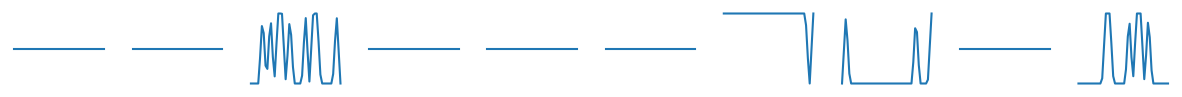

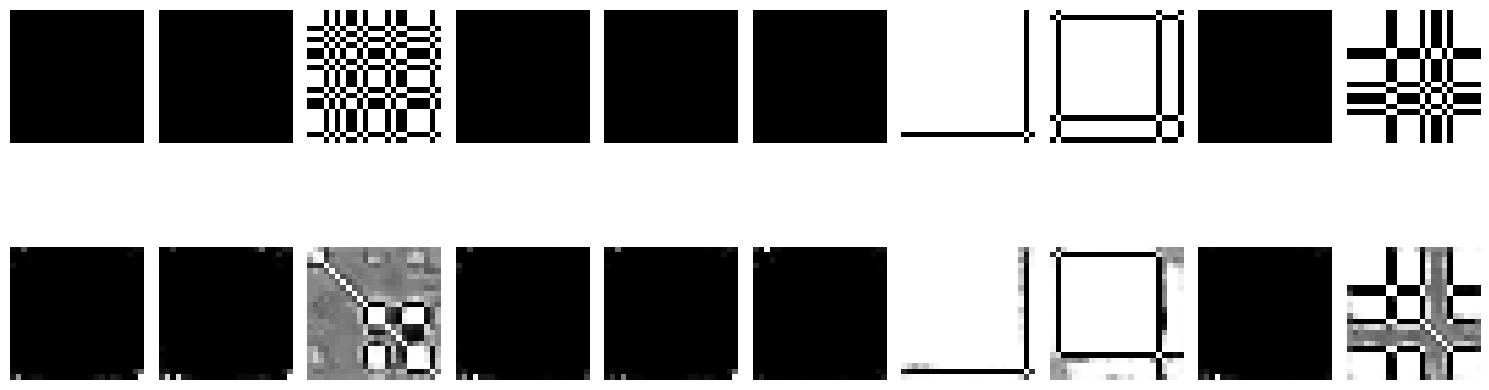

In [ ]:
vae_cnn_inout24_d40_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d40_w24.keras')
visualize_combined(vae_cnn_inout24_d40_w24, x_test_gasf,test_data, latent_dim=40, n=10)

### d=60

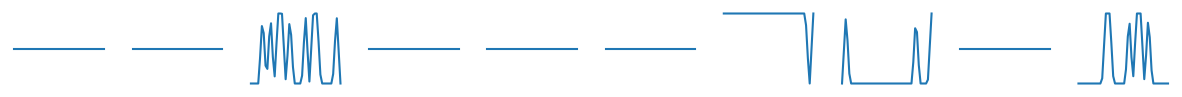

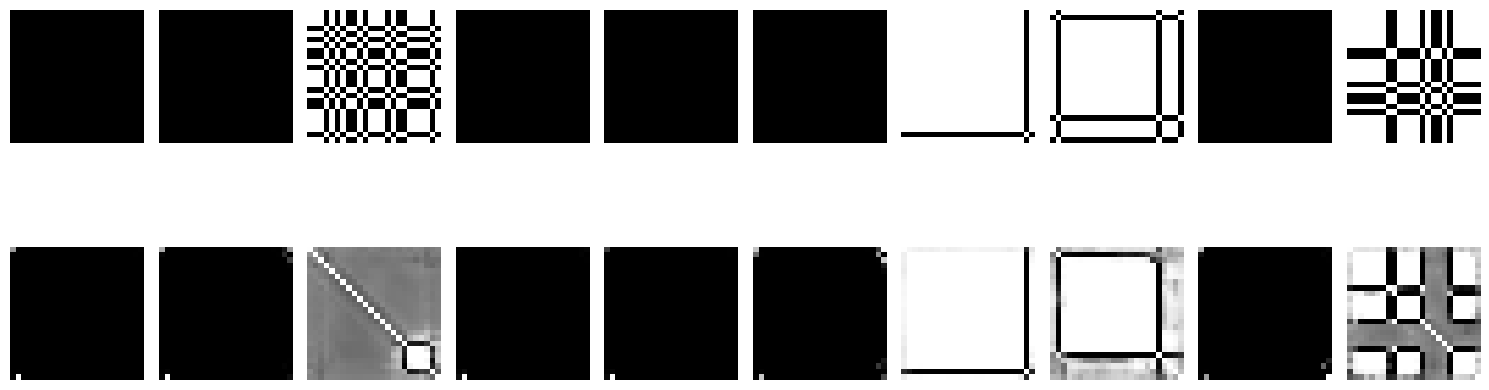

In [ ]:
vae_cnn_inout24_d60_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d60_w24.keras')
visualize_combined(vae_cnn_inout24_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

### d=100

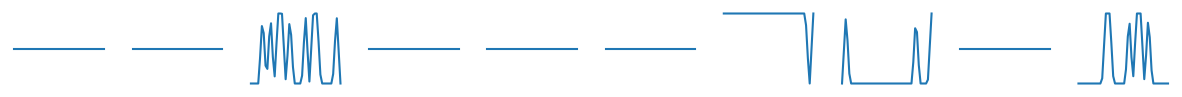

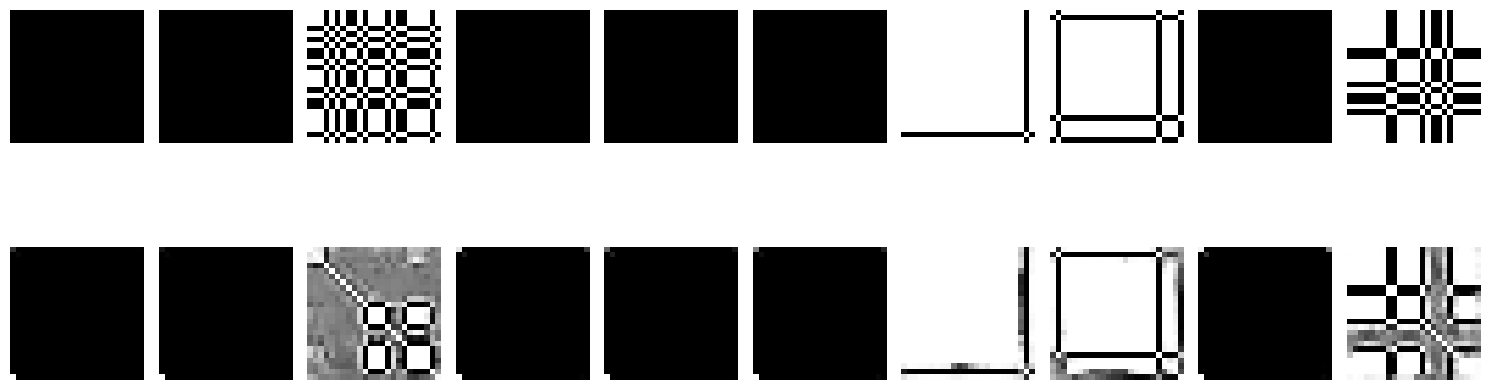

In [ ]:
vae_cnn_inout24_d100_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d100_w24.keras')
visualize_combined(vae_cnn_inout24_d100_w24, x_test_gasf,test_data, latent_dim=100, n=10)

### d=150

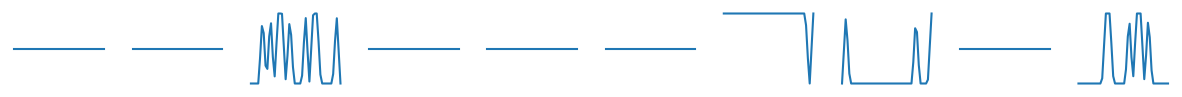

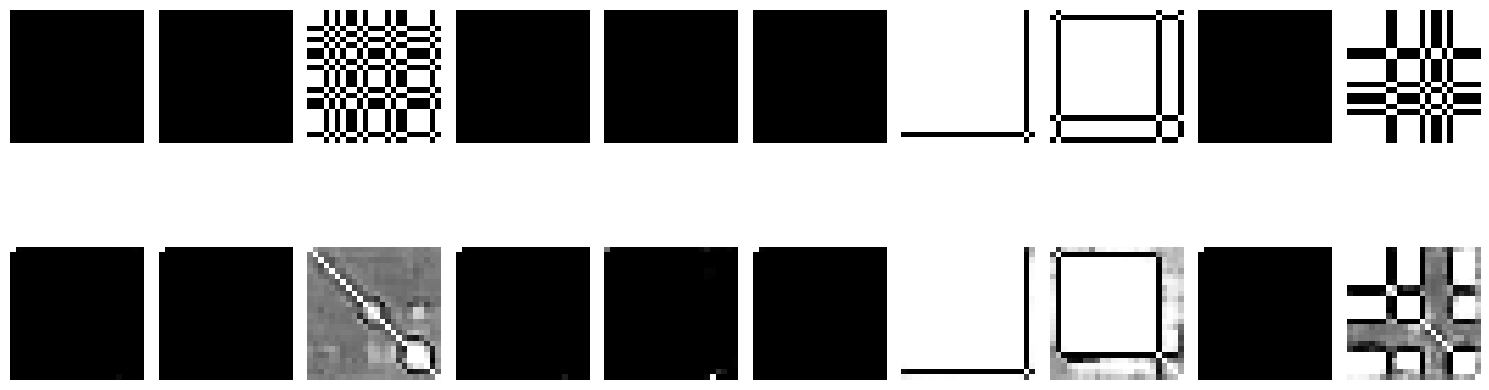

In [ ]:
vae_cnn_inout24_d150_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d150_w24.keras')
visualize_combined(vae_cnn_inout24_d150_w24, x_test_gasf,test_data, latent_dim=150, n=10)

### d=200

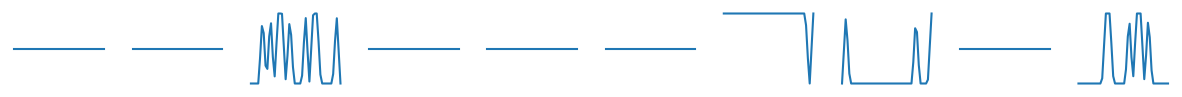

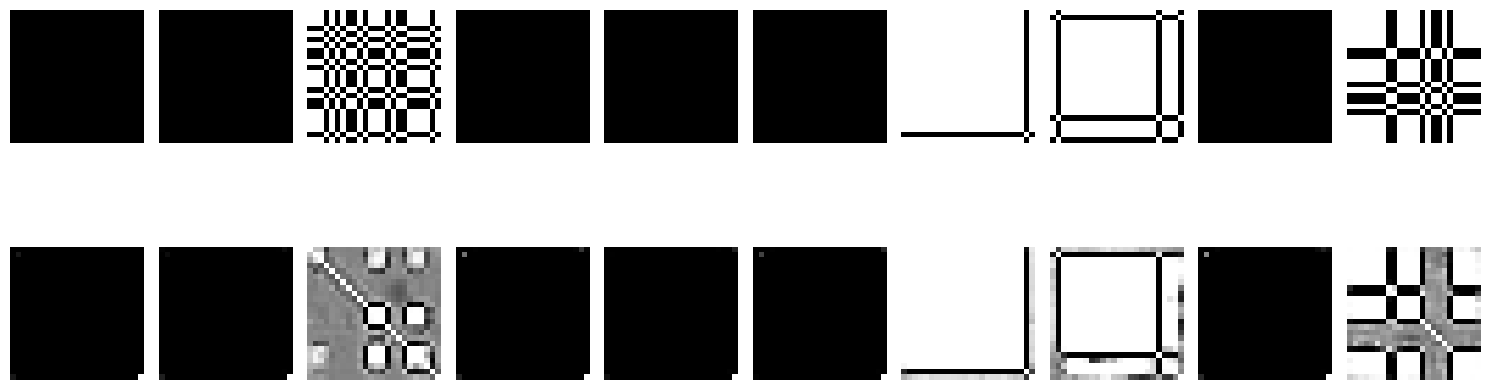

In [ ]:
vae_cnn_inout24_d200_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_inout24_d200_w24.keras')
visualize_combined(vae_cnn_inout24_d200_w24, x_test_gasf,test_data, latent_dim=200, n=10)

## VAE CNN-RNN

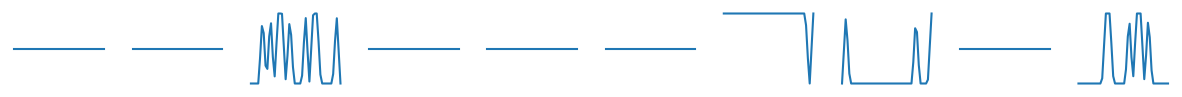

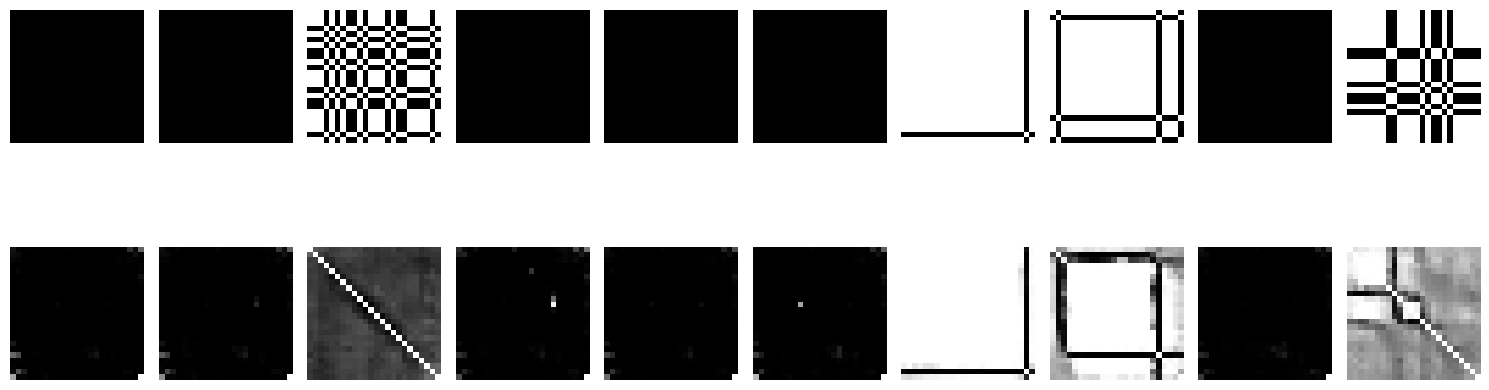

In [ ]:
vae_gru_based_inout24_d40_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_gru_based_inout25_d40_w24.keras')
visualize_combined(vae_gru_based_inout24_d40_w24, x_test_gasf,test_data, latent_dim=40, n=10)

## input and output size = (50,50)

#### d = 10, w = 24

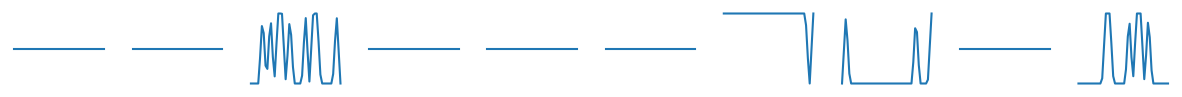

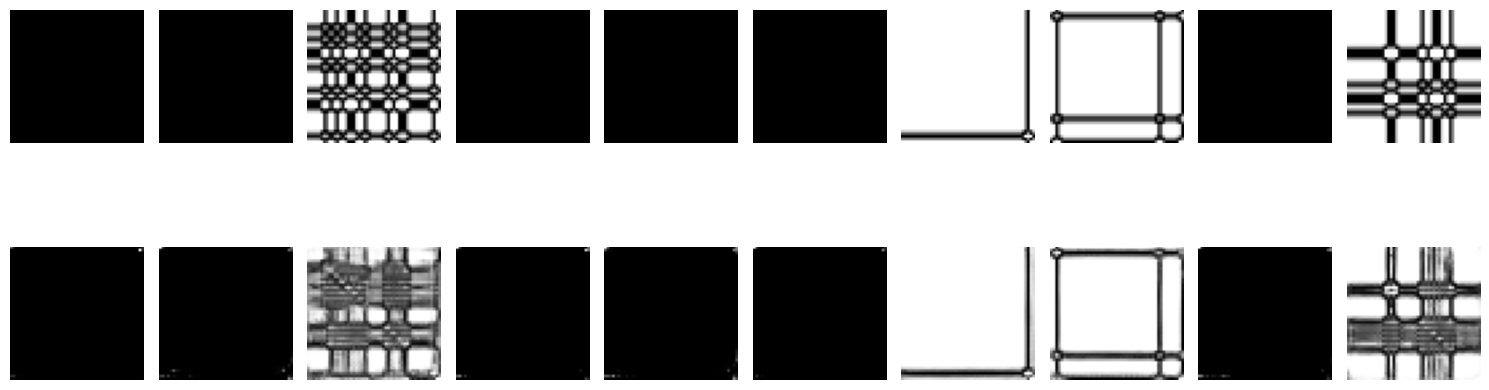

In [ ]:
vae_cnn_d10_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d10_w24.keras')
plt.figure(figsize=(15,1))
for i in range(10):
  plt.subplot(1,10,i+1)
  y = create_linespace(test_data[i],'SensorDateTime_numeric','I3_A')
  plt.plot(y)
  plt.axis('off')
visualize_combined(vae_cnn_d10_w24, x_test_gasf, 10, n=10)

#### d = 10, w = 12

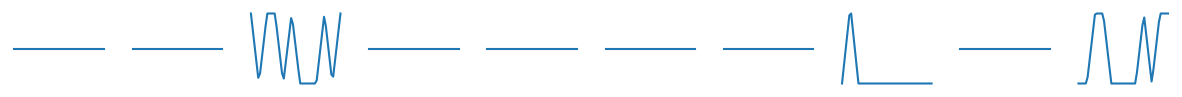

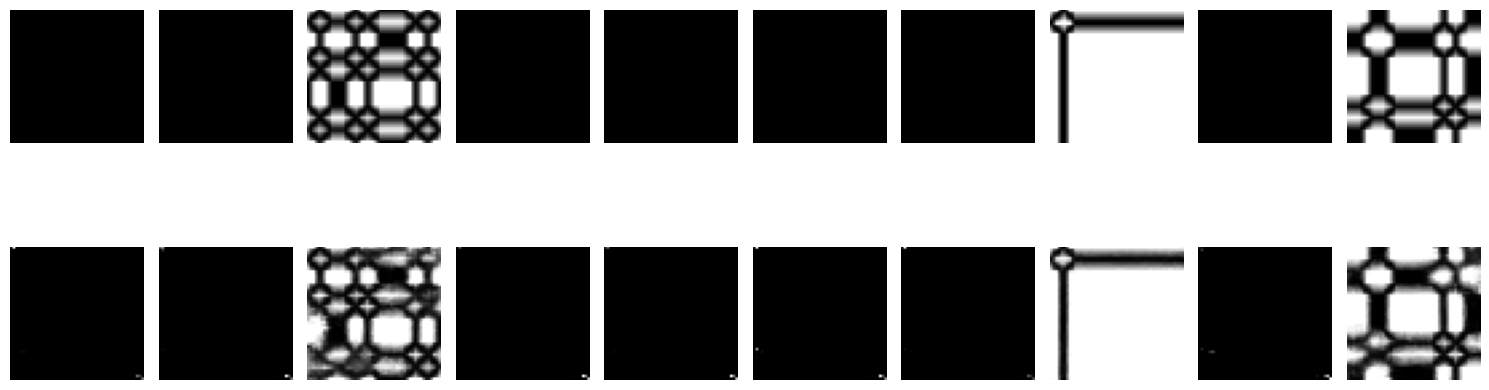

In [ ]:
vae_cnn_d10_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d10_w12.keras')
visualize_combined(vae_cnn_d10_w24, x_test_gasf,test_data, 10, n=10)

#### d = 20, w = 24

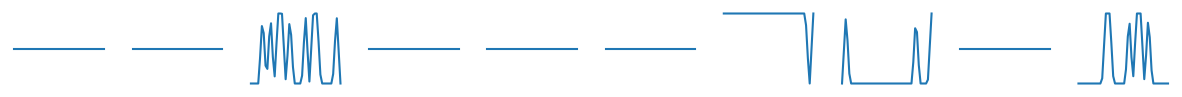

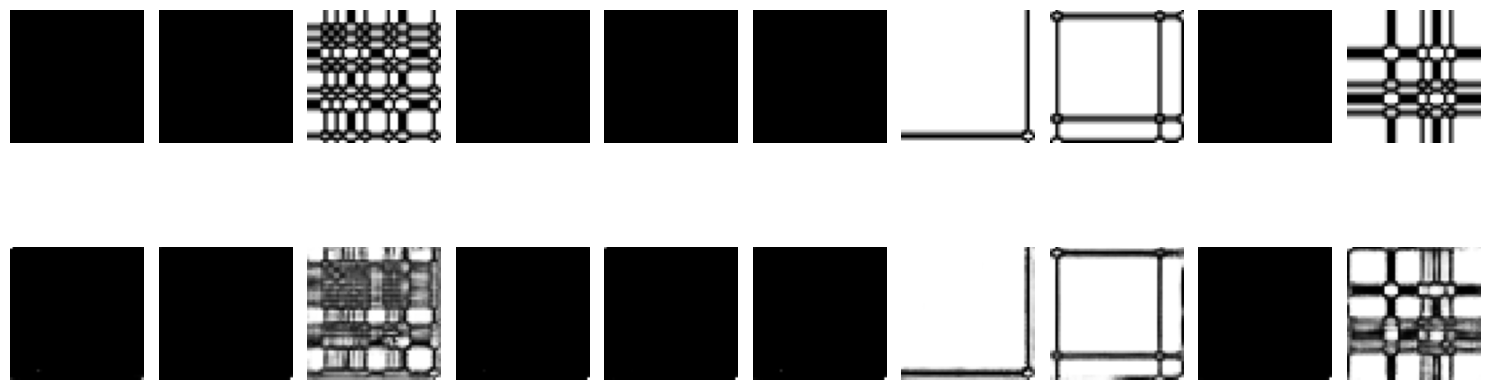

In [ ]:
vae_cnn_d20_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d20_w24.keras')
visualize_combined(vae_cnn_d20_w24, x_test_gasf,test_data, latent_dim=20, n=10)

#### d = 40, w = 24

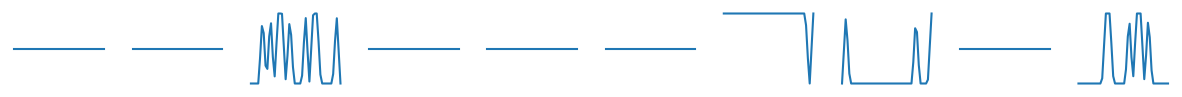

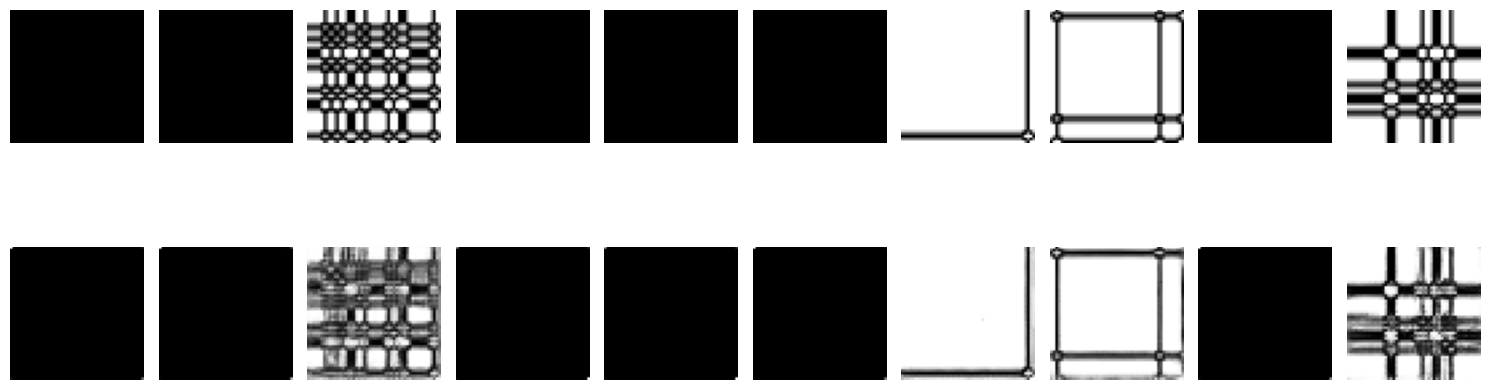

In [ ]:
vae_cnn_d40_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d40_w24.keras')
visualize_combined(vae_cnn_d40_w24, x_test_gasf,test_data, latent_dim=40, n=10)

#### d = 60, w = 24

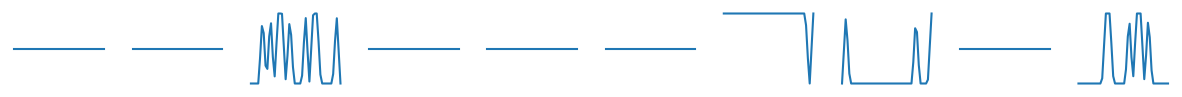

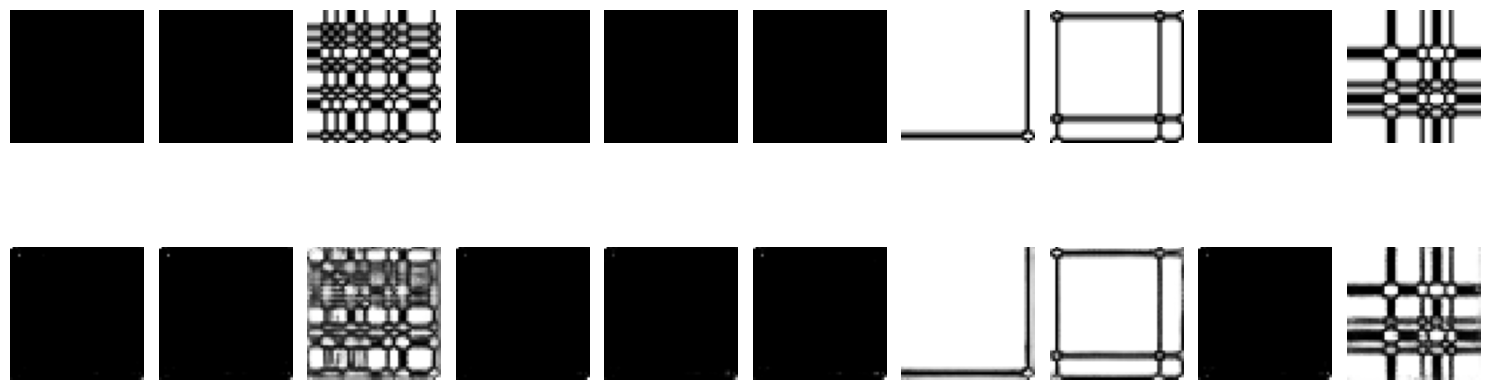

In [ ]:
vae_cnn_d60_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d60_w24.keras')
visualize_combined(vae_cnn_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### d = 128, w = 24

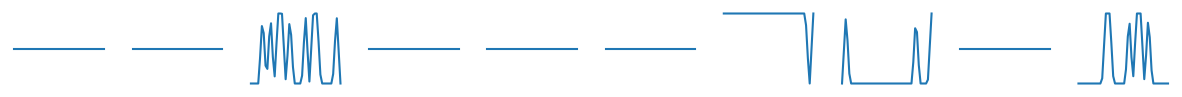

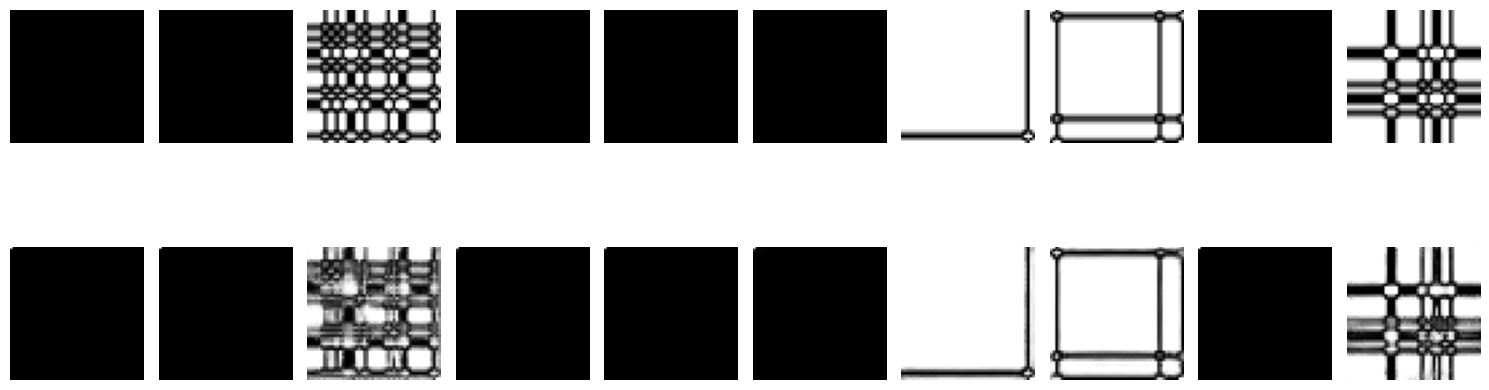

In [ ]:
vae_cnn_d128_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_d128_w24.keras')
visualize_combined(vae_cnn_d128_w24, x_test_gasf,test_data, latent_dim=128, n=10)

#### k = (3,1), d = 60, w = 24

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


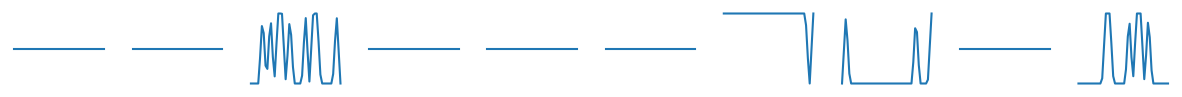

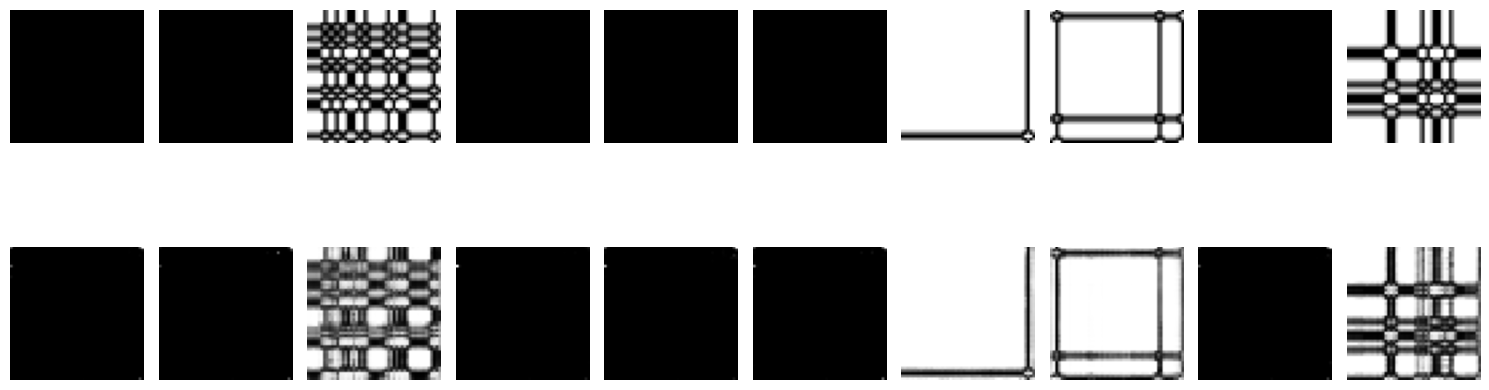

In [ ]:
vae_cnn_k31_60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_k31_d60_w24.keras')
visualize_combined(vae_cnn_k31_60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc_k = (3,1) (1,3), dec_k = (3,3), d = 60, w = 24



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


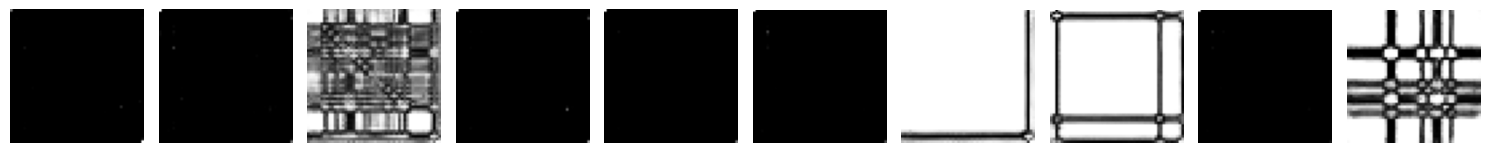

In [ ]:
vae_cnn_enck_31_13_d60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(31,13)_d60_w24.keras')
visualize_reconstructed(vae_cnn_enck_31_13_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc_k = (3,1) then (1,3), dec_k = (3,3), d = 60, w = 24



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


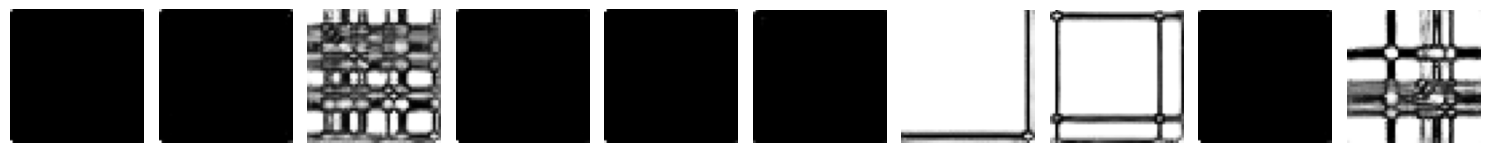

In [ ]:
vae_cnn_enck_31_then_13_d60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(31 then 13)_d60_w24.keras')
visualize_reconstructed(vae_cnn_enck_31_then_13_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc_k = (3,1) then (1,3) and maxpool, dec_k = (3,3), d = 60, w = 24

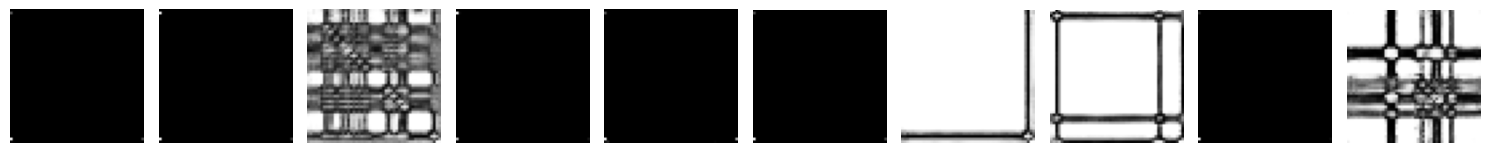

In [ ]:
vae_cnn_enck_31_then_13_mp21_d60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(31 then 13)_mp21_d60_w24.keras')
visualize_reconstructed(vae_cnn_enck_31_then_13_mp21_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc_k = (3,1)(1,3) and maxpool, dec_k = (3,3), d = 60, w = 24

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


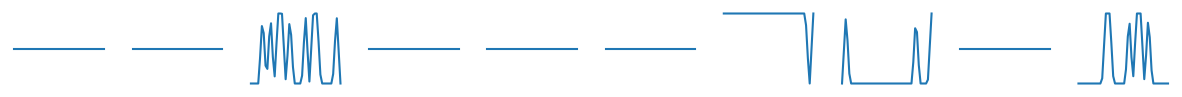

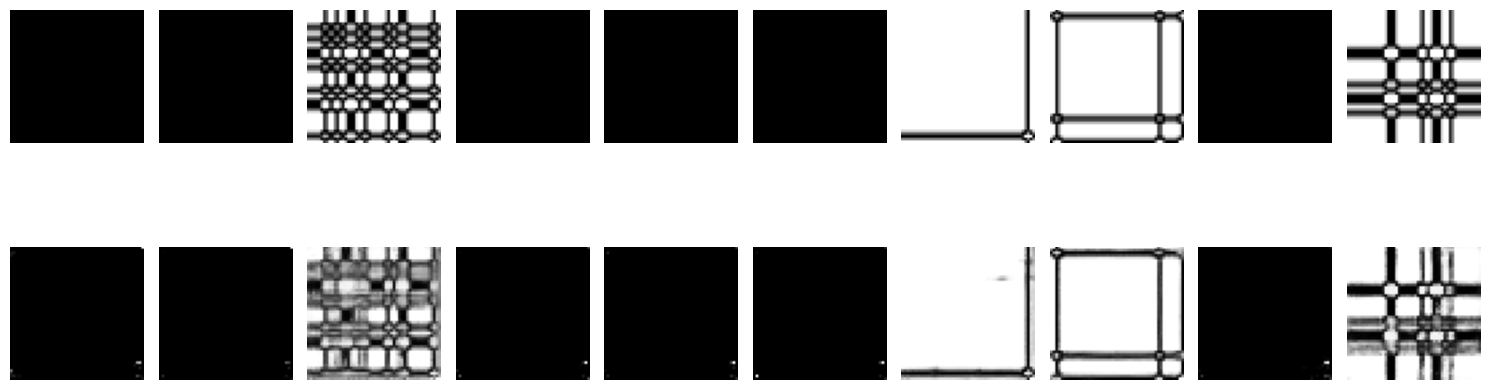

In [ ]:
vae_cnn_ecnk313_d60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(3113)_d60_w24.keras')
visualize_combined(vae_cnn_ecnk313_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc : cnn- gru, d = 60, w = 24

> at loss 373



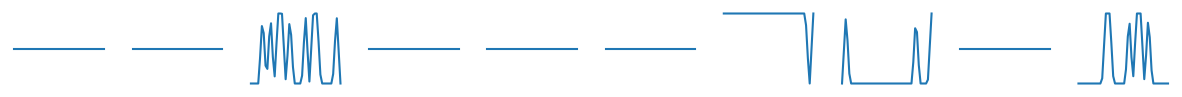

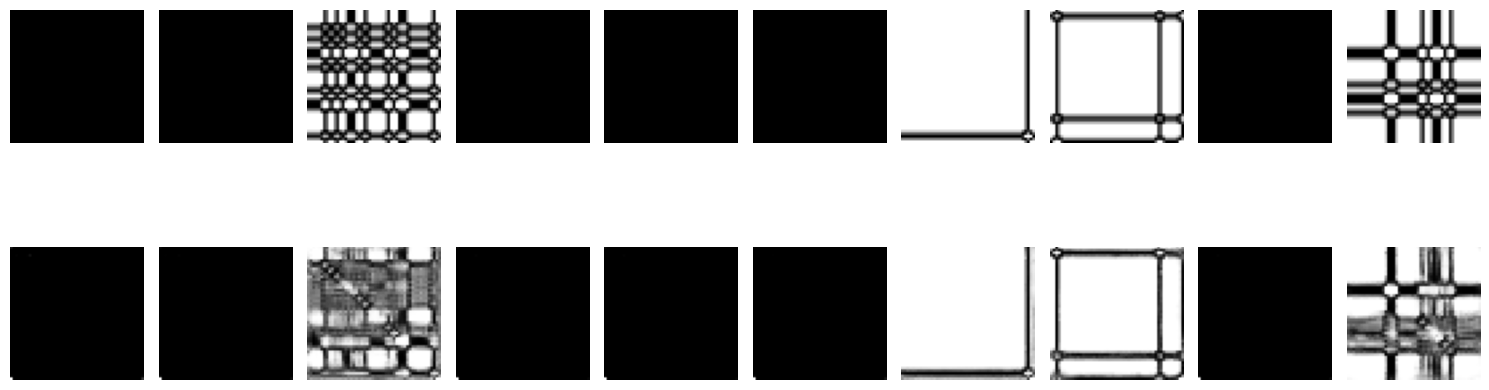

In [ ]:
# vae_cnn_ecnk313_d60_w24.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/vae_cnn_enck(3113)_d60_w24.keras')
visualize_combined(vae_cnn_enc_gru_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc : cnn- gru, d = 60, w = 24

> at loss 365



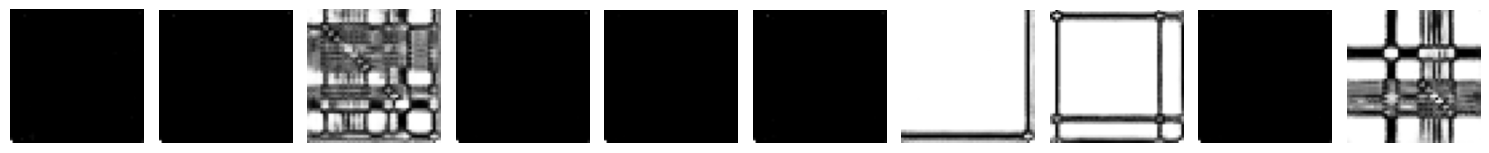

In [ ]:
visualize_reconstructed(vae_cnn_enc_gru_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

#### enc : cnn- gru, d = 60, w = 24

> at loss 362



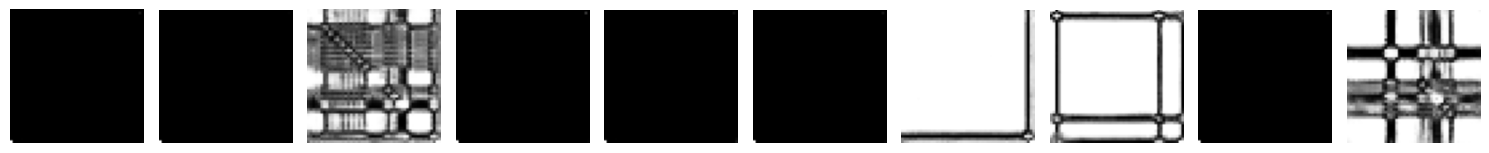

In [ ]:
visualize_reconstructed(vae_cnn_enc_gru_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)

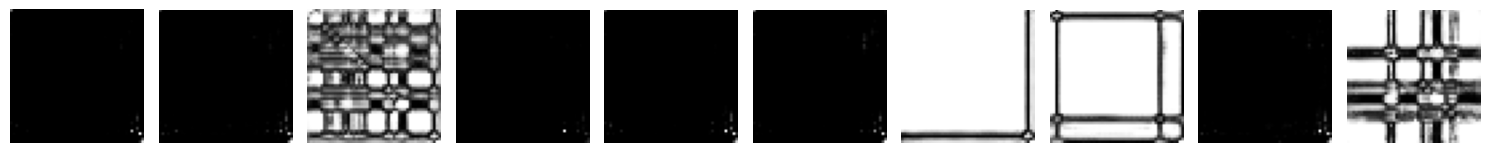

In [ ]:
visualize_reconstructed(vae_cnn_gru_extended_d60_w24, x_test_gasf,test_data, latent_dim=60, n=10)